# PBO against LQR

## Define environment

In [46]:
%load_ext autoreload
%autoreload 2

import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


max_discrete_state = 7
n_discrete_states = 5
discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)
max_discrete_action = 9
n_discrete_actions = 7
discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(max_init_state=max_discrete_state)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Transition: s' = As + Ba
Transition: s' = -1.32s + 5.67a
Reward: Qs² + Ra² + 2 Ssa
Reward: -8.48s² + -4.46a² + -7.95sa


## Collect samples

In [47]:
from pbo.data_collection.replay_buffer import ReplayBuffer


n_samples = 100
epsilon_greedy = 0.7
max_episode_length = 4

replay_buffer = ReplayBuffer()

state = env.reset()
idx_sample = 0
epidose_length = 0

while idx_sample < n_samples:
    if np.random.random() < epsilon_greedy:
        action = env.optimal_action()
    else:
        action = np.random.uniform(discrete_actions[0], discrete_actions[-1], size=1)
    next_state, reward, _, _ = env.step(action)

    replay_buffer.add(state, action, np.array([reward]), next_state)

    epidose_length += 1
    idx_sample += 1

    if epidose_length >= max_episode_length:
        state = env.reset()
        epidose_length = 0
    else:    
        state = next_state


## Visualize samples

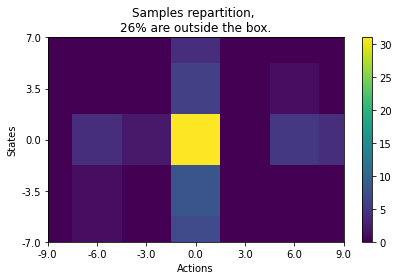

In [48]:
from pbo.data_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visualization_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visualization_mesh.set_values(samples_count)
samples_visualization_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


In [49]:
from pbo.data_collection.dataloader import DataLoader


batch_size = 8
    
replay_buffer.cast_to_jax_array()
data_loader = DataLoader(replay_buffer, batch_size)

## Build networks

In [50]:
import jax 

from pbo.networks.jax.q import FullyConnectedQFunction
from pbo.networks.jax.pbo import LinearPBOFunction


layer_dimension = 3
random_weights_range = 10
gamma = 1
action_range_on_max = 10
n_actions_on_max = 100

seed = 0
key = jax.random.PRNGKey(seed)
key, q_network_key = jax.random.split(key)
random_weights_key, pbo_network_key = jax.random.split(key)

q_function = FullyConnectedQFunction(
    layer_dimension=layer_dimension,
    network_key=q_network_key,
    random_weights_range=random_weights_range,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
)

pbo_function = LinearPBOFunction(pbo_network_key, gamma, q_function)

## Optimal Q function

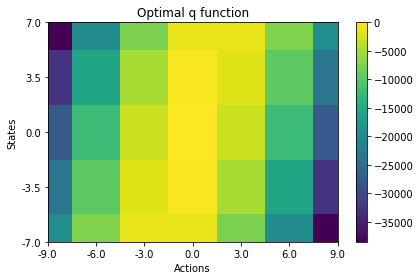

In [51]:
from pbo.utils.compute_Q_lqr import compute_Q_lqr


sleeping_time = 0.4

optimal_Q = compute_Q_lqr(env, discrete_states, discrete_actions, gamma)

q_funcions_visualization_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)

q_funcions_visualization_mesh.set_values(optimal_Q)
q_funcions_visualization_mesh.show("Optimal q function")

## Train Q 
Objective: See if the representation power of the network of Q is powerful enough to represent the optimal Q

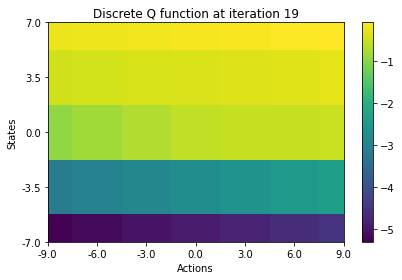

In [55]:
import optax
import jax.numpy as jnp


n_iteration = 20
learning_rate = 0.001

optimizer = optax.sgd(learning_rate=learning_rate)
optimizer_state = optimizer.init(q_function.params)

for iteration in range(n_iteration):
    for state in np.random.permutation(discrete_states):
        for action in np.random.permutation(discrete_actions):
            jax_state = jnp.array([[state]])
            jax_action = jnp.array([[action]])
            target = q_function.network.apply(q_function.params, jax_state, jax_action)
            loss, grad_loss = q_function.l1_loss_and_grad_loss(q_function.params, jax_state, jax_action, target)
            updates, optimizer_state = optimizer.update(
                grad_loss, optimizer_state
            )
            q_function.params = optax.apply_updates(q_function.params, updates)

    # Plot Q network
    discrete_q_network = q_function.get_discrete_q(q_function.params, discrete_states, discrete_actions)

    q_funcions_visualization_mesh.set_values(discrete_q_network)
    q_funcions_visualization_mesh.show(f"Discrete Q function at iteration {iteration}")

## Train PBO

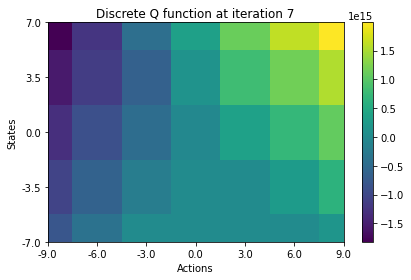

In [56]:
import optax

n_iteration = 8
learning_rate = 0.001

optimizer = optax.sgd(learning_rate=learning_rate)
optimizer_state = optimizer.init(pbo_function.params)

for iteration in range(n_iteration):
    random_weights = q_function.get_random_weights()
    data_loader.shuffle()  # NOT USING JAX: reallly random!!!!

    for batch in data_loader:
        target = pbo_function.compute_target(batch, random_weights)
        loss, grad_loss = pbo_function.loss_and_grad_loss(pbo_function.params, batch, random_weights, target)
        updates, optimizer_state = optimizer.update(
            grad_loss, optimizer_state
        )
        pbo_function.params = optax.apply_updates(pbo_function.params, updates)

    # Plot the fixed point Q network
    fixed_point_params = q_function.convert_to_params(pbo_function.get_fixed_point())
    discrete_q_network = q_function.get_discrete_q(fixed_point_params, discrete_states, discrete_actions)
    
    q_funcions_visualization_mesh.set_values(discrete_q_network)
    q_funcions_visualization_mesh.show(f"Discrete Q function at iteration {iteration}")
    